# Crypto Currency Prediction Model

## Business Understanding
### Objective
The primary objective of this project is to develop a machine learning model capable of predicting the future prices of cryptocurrencies, specifically Bitcoin (BTC-USD) and Ethereum (ETH-USD). The goal is to provide insights that could potentially guide investment decisions and risk management in the volatile cryptocurrency market.

### Importance
Cryptocurrency has emerged as a significant asset class over the past decade. With the increasing adoption of digital currencies and the expansion of blockchain technology, both individual and institutional investors have shown a growing interest in understanding and investing in cryptocurrencies. Accurate price predictions can offer substantial advantages:

- ____Investors____ can better time their entry and exit points in the market, maximizing returns and minimizing losses.
- ____Portfolio Managers____ can improve their asset allocation strategies, incorporating cryptocurrencies as a part of diversified portfolios.
- ____Risk Managers____ can better assess the risk associated with holding cryptocurrencies and take appropriate hedging actions.
- ____Cryptocurrency Exchanges____ can use predictions to provide value-added services to their users, such as advanced trading tools and insights.

### Challenges
The cryptocurrency market is known for its high volatility, influenced by a wide array of factors ranging from regulatory news to technological advancements and market sentiment. This makes the task of price prediction particularly challenging but also rewarding if accurate predictions can be made.

### Project Relevance
By focusing on the prediction of BTC-USD and ETH-USD prices, this project addresses a real-world need for better financial tools in the crypto space. The outcomes of this project could serve as a foundation for developing more sophisticated trading algorithms, risk management frameworks, and investment strategies tailored to the crypto market.

### Stakeholders
The stakeholders of this project include:

- ____Cryptocurrency Traders and Investors:____ Individuals or entities actively trading or investing in cryptocurrencies.
- ____Financial Analysts:____ Professionals analyzing crypto markets for investment firms or media outlets.
- ____Fintech Companies:____ Companies specializing in financial technologies that could leverage predictive models to offer enhanced services.
- ____Data Scientists:____ Researchers or practitioners in the field of data science who can build upon the findings of this project.

In summary, the business understanding phase sets the stage for the project by defining its objectives, explaining its importance, discussing the challenges, and identifying the stakeholders who would benefit from the project's success.

## Data Understanding


### Import Relevant Packages

In [26]:
import requests
import pandas as pd
import numpy as np
from typing import List, Union, Optional, Any
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle

### Define Functions

In [27]:
def fetch_ohlc_data_since_last_entry(pair: str, interval: int, csv_filepath: str):
    """
    Fetches OHLC data from an API and merges it with existing data in a CSV file.

    Parameters
    ----------
    pair : str
        The trading pair to fetch data for.
    interval : int
        The time interval for the data.
    csv_filepath : str
        The filepath of the CSV file to read and write data.

    Returns
    -------
    pd.DataFrame
        The combined DataFrame containing the merged data.

    Notes
    -----
    - The function reads the existing CSV file and checks if it has the expected number of columns.
    - If the CSV file does not exist or has unexpected number of columns, it starts from scratch.
    - The function fetches new data from the API using the provided pair, interval, and last entry time.
    - The new data is merged with the existing data and duplicates are removed.
    - The combined DataFrame is saved back to the CSV file.
    """
    column_names = ['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'number_of_trades']
    numeric_cols = ['open', 'high', 'low', 'close', 'vwap', 'volume', 'number_of_trades']
    last_entry_time = 0  # Initialize last_entry_time

    # Attempt to read the existing CSV file
    try:
        df = pd.read_csv(csv_filepath, names=column_names, header=None)
        # Check if the CSV has the expected number of columns to avoid treating header as data
        if len(df.columns) == len(column_names):
            df.columns = column_names
        else:
            raise ValueError("CSV file has unexpected number of columns.")

        # Ensure 'time' is in datetime format
        last_entry_time = df['time'].astype('int64')
        last_entry_time = last_entry_time.max()
        print(f"Number of entries in the existing CSV before merging: {len(df)}")
        print(f"Last entry time from CSV: {last_entry_time}")
    except (pd.errors.EmptyDataError, FileNotFoundError, ValueError) as e:
        print(f"Error reading CSV file: {e}")
        df = pd.DataFrame(columns=column_names)
        print("Starting from scratch.")

    # Fetch new data from the API
    params = {
        'pair': pair,
        'interval': interval,
        'since': last_entry_time
    }
    resp = requests.get('https://api.kraken.com/0/public/OHLC', params=params)

    if resp.status_code == 200:
        data = resp.json()
        ohlc_data = data['result'][list(data['result'].keys())[0]]
        new_df = pd.DataFrame(ohlc_data, columns=column_names)
        new_df[numeric_cols] = new_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

        # Concatenate the old and new data
        combined_df = pd.concat([df, new_df], ignore_index=True)

        # Remove duplicates, keeping the last occurrence
        combined_df.drop_duplicates(subset=['time'], keep='last', inplace=True)

        # Save the combined DataFrame back to the CSV file
        combined_df.to_csv(csv_filepath, index=False, header=False)

        combined_df['time'] = pd.to_datetime(combined_df['time'], unit='s')

        print(f"Combined data has {len(combined_df)} entries after merging.")
        return combined_df
    else:
        print(f"Error: {resp.status_code}")
        return df

In [28]:
def add_technical_indicators(X: Union[pd.DataFrame, np.ndarray], y: Optional[Union[pd.Series, np.ndarray]] = None, **kwargs: Any):
    """
    Add technical indicators as features to the input DataFrame.

    Parameters
    ----------
    X : Union[pd.DataFrame, np.ndarray]
        The input DataFrame or array.
    y : Optional[Union[pd.Series, np.ndarray]], optional
        The target variable, by default None.
    **kwargs : Any
        Additional keyword arguments for calculating the technical indicators.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the new features.
    """
    # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X).copy()
    else:
        X = X.copy()

    # Calculate each technical indicator using the provided periods
    X[f'SMA_{kwargs["sma_period"]}'] = calculate_sma(X['close'], kwargs['sma_period'])
    X[f'EMA_{kwargs["ema_period"]}'] = calculate_ema(X['close'], kwargs['ema_period'])
    X[f'RSI_{kwargs["rsi_period"]}'] = calculate_rsi(X['close'], kwargs['rsi_period'])
    macd, signal = calculate_macd(X['close'], kwargs['macd_fast_period'], kwargs['macd_slow_period'], kwargs['macd_signal_period'])
    X['MACD'] = macd
    X['MACD_Signal'] = signal
    upper_band, lower_band = calculate_bollinger_bands(X['close'], kwargs['bollinger_period'], kwargs['bollinger_std_dev'])
    X['Bollinger_Upper'] = upper_band
    X['Bollinger_Lower'] = lower_band

    # Return the DataFrame with the new features
    return X

In [29]:
def calculate_sma(data: pd.Series, period: int):
    """
    Calculate the Simple Moving Average (SMA) of a given data series.

    Parameters
    ----------
    data : pd.Series
        The data series for which to calculate the SMA.
    period : int
        The period over which to calculate the SMA.

    Returns
    -------
    pd.Series
        The SMA of the data series.
    """
    return data.rolling(window=period).mean()

In [30]:
def calculate_ema(data: pd.Series, period: int):
    """
    Calculate the Exponential Moving Average (EMA) of a given data series.

    Parameters
    ----------
    data : pd.Series
        The input data series.
    period : int
        The period for calculating the EMA.

    Returns
    -------
    pd.Series
        The EMA of the input data series.
    """
    return data.ewm(span=period, adjust=False).mean()

In [31]:
def calculate_rsi(data: pd.Series, period: int):
    """
    Calculate the Relative Strength Index (RSI) for a given data series.

    Parameters:
    data (pd.Series): The data series for which to calculate RSI.
    period (int): The number of periods to use for the RSI calculation.

    Returns:
    pd.Series: The RSI values for the given data series.
    """
    delta = data.diff(1)  # Calculate the difference between consecutive values
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()  # Calculate the average gain over the specified period
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()  # Calculate the average loss over the specified period
    rs = gain / loss  # Calculate the relative strength
    rsi = 100 - (100 / (1 + rs))  # Calculate the RSI
    return rsi

In [32]:
def calculate_macd(data: List[float], fast_period: int, slow_period: int, signal_period: int):
    """
    Calculate the MACD (Moving Average Convergence Divergence) line and signal line.

    Parameters:
    - data (List[float]): The input data.
    - fast_period (int): The period for the fast EMA (Exponential Moving Average).
    - slow_period (int): The period for the slow EMA (Exponential Moving Average).
    - signal_period (int): The period for the signal line EMA (Exponential Moving Average).

    Returns:
    - Tuple[List[float], List[float]]: A tuple containing the MACD line and signal line.

    """
    fast_ema = calculate_ema(data, fast_period)  # Calculate the fast EMA
    slow_ema = calculate_ema(data, slow_period)  # Calculate the slow EMA
    macd_line = fast_ema - slow_ema  # Calculate the MACD line
    signal_line = calculate_ema(macd_line, signal_period)  # Calculate the signal line
    return macd_line, signal_line

In [33]:
def calculate_bollinger_bands(data: pd.Series, period: int, std_dev: int):
    """
    Calculate the upper and lower Bollinger Bands.

    Parameters:
    data (pd.Series): The input data.
    period (int): The period for calculating the moving average and standard deviation.
    std_dev (int): The number of standard deviations to use for calculating the bands.

    Returns:
    Tuple[pd.Series, pd.Series]: A tuple containing the upper and lower Bollinger Bands.
    """
    sma = data.rolling(window=period).mean()  # Calculate the simple moving average
    rolling_std = data.rolling(window=period).std()  # Calculate the rolling standard deviation
    upper_band = sma + (rolling_std * std_dev)  # Calculate the upper Bollinger Band
    lower_band = sma - (rolling_std * std_dev)  # Calculate the lower Bollinger Band
    return upper_band, lower_band


### Access the data

In [34]:
# Update BTC data
btc_df = fetch_ohlc_data_since_last_entry('XBTUSD', 1440, 'data/XBTUSD_1440.csv')

# Update ETH data
eth_df = fetch_ohlc_data_since_last_entry('ETHUSD', 1440, 'data/ETHUSD_1440.csv')


Number of entries in the existing CSV before merging: 3806
Last entry time from CSV: 1710806400
Combined data has 3806 entries after merging.
Number of entries in the existing CSV before merging: 3142
Last entry time from CSV: 1710806400
Combined data has 3142 entries after merging.


### Explore the data

In [35]:
btc_df.describe()

,open,high,low,close,vwap,volume,number_of_trades
count,3806.000000,3806.000000,3806.000000,3806.000000,3806.000000,3806.000000,722.000000
mean,14088.013511,14449.765680,13689.201241,14104.974237,8594.399033,13072.234120,29348.674515
std,16740.840546,17164.883808,16256.899591,16759.715031,11776.829306,18715.684639,14760.575051
min,122.000000,122.000000,122.000000,122.000000,0.000038,1.000000,8290.000000
25%,643.685757,659.850000,627.000000,643.298750,785.114053,766.500000,20050.000000
50%,7362.550000,7563.600000,7183.100000,7367.700000,3840.976601,5027.102328,25422.500000
75%,23166.075000,23712.775000,22717.250000,23176.450000,9970.462040,19057.750000,34289.500000
max,73089.700000,73734.000000,71336.100000,73082.400000,72897.100000,238569.000000,112409.000000


In [36]:
btc_df.dtypes

time                datetime64[ns]
open                       float64
high                       float64
low                        float64
close                      float64
vwap                       float64
volume                     float64
number_of_trades           float64
dtype: object

In [37]:
eth_df.describe()

,open,high,low,close,vwap,volume,number_of_trades
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,722.000000
mean,971.444174,1001.580697,936.990668,972.464707,48946.324342,18541.397849,16919.746537
std,1119.852031,1152.918276,1081.430222,1120.498289,60611.806956,20941.725224,13551.050721
min,0.430000,0.471860,0.150000,0.419990,0.744430,1.000000,2706.000000
25%,136.435000,140.435000,131.620000,136.430000,2912.280000,4951.000000,9204.750000
50%,360.260000,374.264990,347.480000,361.945000,32622.881904,13059.500000,14175.500000
75%,1716.275000,1762.735000,1665.010000,1716.695000,66272.821581,25135.004882,20898.500000
max,4811.620000,4867.000000,4715.290000,4811.610000,770373.301852,229817.780298,172650.000000


In [38]:
eth_df.dtypes

time                datetime64[ns]
open                       float64
high                       float64
low                        float64
close                      float64
vwap                       float64
volume                     float64
number_of_trades           float64
dtype: object

In [39]:
# Now both btc_df and eth_df have identical 'time' columns and their own data
# Rename the columns to indicate their source, except for the 'time' column
btc_df = btc_df.rename(columns=lambda x: x if x == 'time' else f"btc_{x}")
eth_df = eth_df.rename(columns=lambda x: x if x == 'time' else f"eth_{x}")

# Merge the dataframes on the 'time' column
merged_df = pd.merge(btc_df, eth_df, on='time')

# Now, split the merged dataframe back into two original dataframes
# by selecting the columns based on the prefix you added
btc_columns = [col for col in merged_df if col.startswith('btc_')] + ['time']
eth_columns = [col for col in merged_df if col.startswith('eth_')] + ['time']

btc_df_original = merged_df[btc_columns].rename(columns=lambda x: x.replace('btc_', ''))
eth_df_original = merged_df[eth_columns].rename(columns=lambda x: x.replace('eth_', ''))

print(btc_df['time'].equals(eth_df['time']))  

print(btc_df_original['time'].equals(eth_df_original['time']))  

False
True


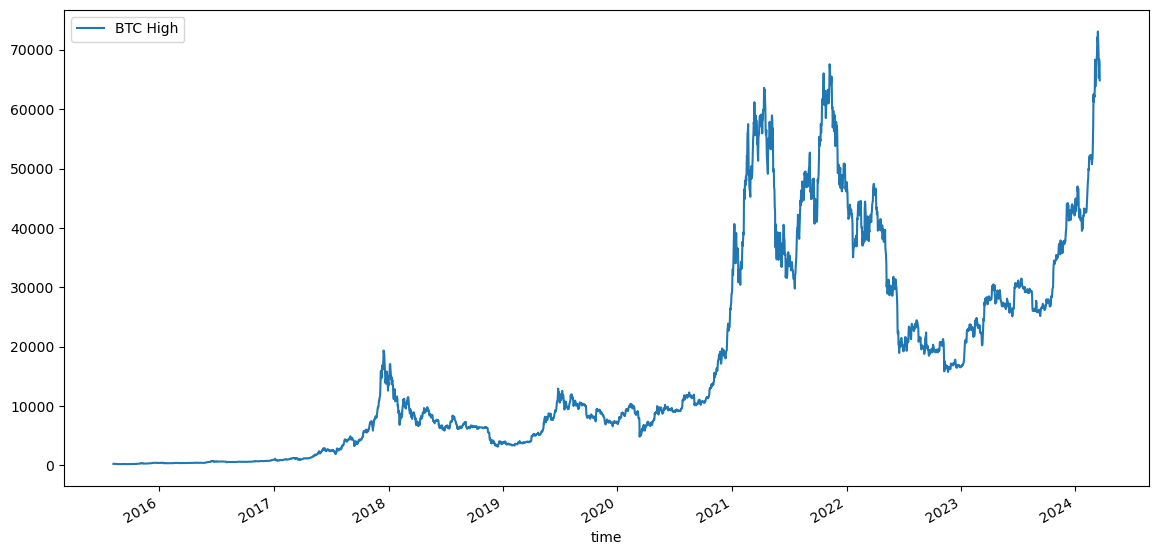

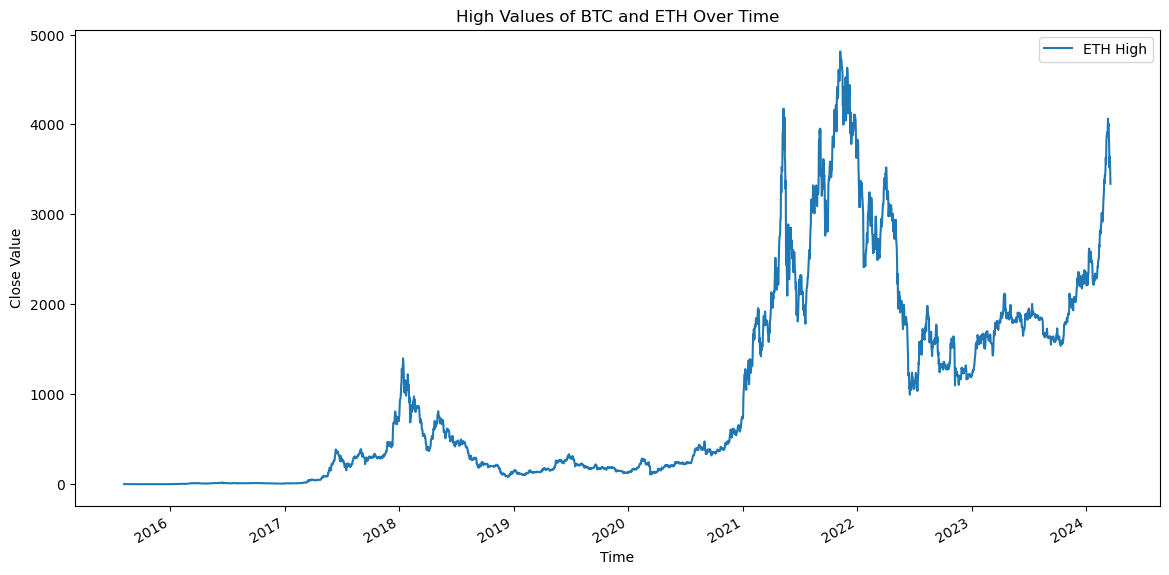

In [40]:
# Plot 'high' values for btc_df
btc_df_original.plot(x='time', y='close', label='BTC High', figsize=(14, 7))

# Plot 'high' values for eth_df
eth_df_original.plot(x='time', y='close', label='ETH High', figsize=(14, 7))

plt.title('High Values of BTC and ETH Over Time')
plt.xlabel('Time')
plt.ylabel('Close Value')
plt.legend()
plt.show()

In [41]:
# Set 'time' as the index for both DataFrames
btc_df_original.set_index('time', inplace=True)
eth_df_original.set_index('time', inplace=True)

# Join the two DataFrames on the 'time' index
# Use an inner join to only keep rows that appear in both DataFrames
combined_df = btc_df_original.join(eth_df_original, lsuffix='_btc', rsuffix='_eth', how='inner')

# Calculate the correlation matrix for the joined DataFrame
correlation_matrix = combined_df.corr()

# If you want to see the correlation between the 'close' prices of BTC and ETH, for example
high_correlation = correlation_matrix.loc['high_btc', 'high_eth']
close_correlation = correlation_matrix.loc['close_btc', 'close_eth']

print("\nCorrelation between BTC High and ETH High:", high_correlation)
print("\nCorrelation between BTC Close and ETH Close:", close_correlation)


Correlation between BTC High and ETH High: 0.9436823161793274

Correlation between BTC Close and ETH Close: 0.9444032068457316


We can see that there is a correlation between BTCUSD highs and ETHUSD highs. Thats why we are going to use one trading pair as training pair and the other as test/validation pair.

## Data Preparation

### Create new colums

In [42]:
# For btc_df
btc_df_original['next_high'] = btc_df_original['high'].shift(-1)
btc_df_original['next_high_2perc'] = (btc_df_original['next_high'] - btc_df_original['close']) / btc_df_original['close'] > 0.02

# For eth_df
eth_df_original['next_high'] = eth_df_original['high'].shift(-1)
eth_df_original['next_high_2perc'] = (eth_df_original['next_high'] - eth_df_original['close']) / eth_df_original['close'] > 0.02


In [43]:
btc_df_original.head()

,open,high,low,close,vwap,volume,number_of_trades,next_high,next_high_2perc
time,,,,,,,,,
2015-08-07,278.67000,290.00000,274.15182,280.85541,62.785617,58.0,NaN,283.77999,False
2015-08-08,280.28011,283.77999,259.20268,264.20000,29.299671,96.0,NaN,270.00000,True
2015-08-11,264.20000,270.00000,260.00000,270.00000,99.121754,162.0,NaN,270.00000,False
2015-08-12,268.97047,270.00000,265.48598,267.02540,61.308811,98.0,NaN,268.00000,False
2015-08-13,267.47934,268.00000,261.64370,265.19999,138.976184,229.0,NaN,270.00000,False


In [44]:
eth_df_original.head()

,open,high,low,close,vwap,volume,number_of_trades,next_high,next_high_2perc
time,,,,,,,,,
2015-08-07,3.00000,3.00001,3.00000,3.00000,123.930568,4.0,NaN,3.0000,False
2015-08-08,3.00000,3.00000,0.15000,1.19999,1942.888147,20.0,NaN,1.1500,False
2015-08-11,0.79969,1.15000,0.65038,0.99000,9234.568705,84.0,NaN,1.2880,True
2015-08-12,1.00000,1.28800,0.90500,1.28800,1736.114983,46.0,NaN,1.8848,True
2015-08-13,1.26280,1.88480,1.26280,1.88480,2815.450762,61.0,NaN,2.1000,True


### Create test and training data

In [45]:
# Drop rows with missing values in the training set
train_df = btc_df_original.dropna(subset=['next_high','next_high_2perc'])
X_train = train_df[['open', 'high', 'low', 'close', 'vwap', 'volume']]
y_train = train_df['next_high_2perc']

# Drop rows with missing values in the testing/validation set
test_df = eth_df_original.dropna(subset=['next_high','next_high_2perc'])
X_test = test_df[['open', 'high', 'low', 'close', 'vwap', 'volume']]
y_test = test_df['next_high_2perc']

## Categorical Analysis

#### Random Forest

In [46]:
# Initialize the classifier
classifier = RandomForestClassifier()

# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Predict on the training data (for evaluation purposes)
train_predictions = classifier.predict(X_train)

# Evaluate the classifier on the training data using accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy}")

# Predict on the test data
test_predictions = classifier.predict(X_test)

# Evaluate the classifier on the test data using accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Classification report (includes precision, recall, and F1-score)
class_report = classification_report(y_test, test_predictions)
print("Classification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Training Accuracy: 1.0
Test Accuracy: 0.5676536134988857
Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.07      0.13      1413
        True       0.56      0.97      0.71      1728

    accuracy                           0.57      3141
   macro avg       0.62      0.52      0.42      3141
weighted avg       0.61      0.57      0.45      3141

Confusion Matrix:
[[ 104 1309]
 [  49 1679]]


In summary, the model is biased towards predicting the 'True' class, as evidenced by the high recall for 'True' and low recall for 'False'. The model's ability to generalize is poor, and it is likely overfitted to the training data. To improve the model, you might consider collecting more data, simplifying the model, applying regularization techniques, or using methods to balance the classes.

#### Trying to optimize Random Forest

In [47]:
# Initialize the model with some parameters to potentially reduce overfitting
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limit the depth of the trees
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    oob_score=True  # Enable OOB scoring
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Get the OOB score
oob_score = rf_model.oob_score_
print(f"OOB Score: {oob_score}")

# Perform cross-validation to get a better estimate of the model's performance
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy: {cv_scores.mean()}")

# Predict on the training data (for evaluation purposes)
train_predictions = rf_model.predict(X_train)

# Evaluate the model on the training data using accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy}")

# Predict on the test data
test_predictions = rf_model.predict(X_test)

# Evaluate the model on the test data using accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Classification report (includes precision, recall, and F1-score)
class_report = classification_report(y_test, test_predictions)
print("Classification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

OOB Score: 0.6456542502387774
Cross-validated Accuracy: 0.5549127621439348
Training Accuracy: 0.778414517669532
Test Accuracy: 0.5752944921999363
Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.09      0.17      1413
        True       0.57      0.97      0.72      1728

    accuracy                           0.58      3141
   macro avg       0.64      0.53      0.44      3141
weighted avg       0.63      0.58      0.47      3141

Confusion Matrix:
[[ 132 1281]
 [  53 1675]]


In summary, the model is better at identifying 'True' cases but struggles with 'False' cases, leading to a high number of false positives. This could be due to class imbalance or features that do not adequately capture the characteristics of the 'False' class. To improve the model, consider techniques such as resampling to address class imbalance, feature engineering to better distinguish between classes, or model tuning to reduce overfitting.

#### Executing Grid Search on Random Forest

In [48]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100, 200, 300]
}

# Initialize the grid search for RandomForestClassifier
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',  # Use accuracy for classification
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Evaluate the best model found by the grid search
best_rf_model = grid_search.best_estimator_

# Predict on the training data
train_predictions = best_rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy}")

# Predict on the test data
test_predictions = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Classification report (includes precision, recall, and F1-score)
class_report = classification_report(y_test, test_predictions)
print("Classification Report:")
print(class_report)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training Accuracy: 0.801655523718561
Test Accuracy: 0.5660617637695001
Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.06      0.11      1413
        True       0.56      0.98      0.71      1728

    accuracy                           0.57      3141
   macro avg       0.64      0.52      0.41      3141
weighted avg       0.63      0.57      0.44      3141

Confusion Matrix:
[[  84 1329]
 [  34 1694]]


In summary, the model is heavily biased towards predicting the 'True' class, resulting in a high number of false positives for the 'False' class. The low recall for 'False' and the high recall for 'True' suggest that the model is not effectively distinguishing between the two classes. To improve the model, it should be considered implementing strategies to combat overfitting, such as cross-validation, regularization, or pruning. Additionally, addressing the class imbalance with techniques like resampling or using different performance metrics that are less sensitive to class imbalance, such as the area under the receiver operating characteristic curve (AUC-ROC), may also help improve model performance.

#### Create new Features and Further Optimization

The following code block runs for aprox. 30 minutes.
Following settings impact the run time:
- Possible parameters for the different features in preprocess__kw_args
- Number of random parameter sets created for preprocess__kw_args
- Number of iterations (n_iter) used in random_search
- Number of cross validations (cv) used in random_search
- Number of jobs (n_jobs) used in random_search

Playing with those settings might create better results but also impact the runtime of the model creation.

In [55]:
# Define the pipeline with the FunctionTransformer and imputation
pipeline_with_transformer = Pipeline([
    ('preprocess', FunctionTransformer(add_technical_indicators, validate=False)),  # No kw_args here
    ('impute', SimpleImputer(strategy='mean')),  # Impute missing values
    ('model', RandomForestClassifier(random_state=42))
])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'preprocess__kw_args': [
        {
            'sma_period': randint(5, 15).rvs(),
            'ema_period': randint(5, 15).rvs(),
            'rsi_period': randint(10, 20).rvs(),
            'macd_fast_period': randint(8, 17).rvs(),
            'macd_slow_period': randint(19, 35).rvs(),
            'macd_signal_period': randint(5, 15).rvs(),
            'bollinger_period': randint(10, 30).rvs(),
            'bollinger_std_dev': randint(1, 3).rvs()
        }
        for _ in range(100)  # Generate 5 random parameter sets
    ],
    'model__n_estimators': randint(100, 1000),
    'model__max_depth': randint(3, 10),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20),
    'model__max_features': [1.0, 'sqrt', 'log2', None]
}
# Define a custom scorer
scorer = make_scorer(accuracy_score)

# Prepare the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_with_transformer,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,        # 5-fold cross-validation
    verbose=1,   # Controls the verbosity: the higher, the more messages
    random_state=42,
    n_jobs=1,   # Number of jobs to run in parallel (-1 means using all processors)
    scoring=scorer  # Use the custom scorer
)

# Run the random search
random_search.fit(X_train, y_train)

# Output the best parameters and score found by RandomizedSearchCV
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

# Extract the best pipeline
best_pipeline = random_search.best_estimator_

# Apply transformations to X_test
X_test_transformed = best_pipeline.named_steps['preprocess'].transform(X_test)

# Now X_test_transformed contains the technical indicators with the best parameters

#print(X_train.head())

# Predict on the training data
train_predictions = random_search.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy}")

#print(X_test.head())

# Evaluate the best model on the test/validation data
y_pred = random_search.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

# Classification report (includes precision, recall, and F1-score)
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print(y_pred[-1:])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'model__max_depth': 3, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 4, 'model__n_estimators': 783, 'preprocess__kw_args': {'sma_period': 14, 'ema_period': 6, 'rsi_period': 11, 'macd_fast_period': 10, 'macd_slow_period': 19, 'macd_signal_period': 5, 'bollinger_period': 27, 'bollinger_std_dev': 2}}
Best Score: 0.590575476188065
Training Accuracy: 0.6602992677491245
Test Accuracy: 0.5673352435530086
Classification Report:
              precision    recall  f1-score   support

       False       0.52      0.54      0.53      1413
        True       0.61      0.59      0.60      1728

    accuracy                           0.57      3141
   macro avg       0.56      0.56      0.56      3141
weighted avg       0.57      0.57      0.57      3141

Confusion Matrix:
[[ 760  653]
 [ 706 1022]]
[False]


In summary, the model shows a better ability to identify 'True' cases over 'False' cases, but there is a significant number of both false positives and false negatives. The model's overall accuracy is moderate, and the balance between precision and recall is not optimal for either class. To improve the model, it should be considered exploring feature selection, model tuning, or different algorithms. Additionally, techniques to address potential class imbalance could be beneficial, as well as further investigation into why the model is more challenged by the 'False' class.

In [50]:
with open('model/cryptopredictionmodel.pkl', 'wb') as file:
    pickle.dump(random_search, file)